# Big Data

Things to consider

- Multi-threaded encoding
- Filter out drums (track 10)

In [1]:
import os
os.chdir(r'8 - Big Data')
from midi_encoding import *
from data_loading import *
from pathlib import Path
import music21 as m21
import random
import pretty_midi
import IPython.display
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

### Lakh MIDI DataSet

In [2]:
midi_path = Path('../data/midi/lakh_clean')
midi_file_paths = list(midi_path.rglob('*.mid'))
len(midi_file_paths)

17256

In [3]:
midi_file_paths[0:5]

[PosixPath('../data/midi/lakh_clean/.38 Special/Caught Up In You.mid'),
 PosixPath('../data/midi/lakh_clean/.38 Special/Fantasy Girl.mid'),
 PosixPath('../data/midi/lakh_clean/10,000 Maniacs/A Campfire Song.mid'),
 PosixPath('../data/midi/lakh_clean/101 Strings/Theme From The Godfather.mid'),
 PosixPath('../data/midi/lakh_clean/10cc/Dreadlock Holiday.1.mid')]

In [4]:
file_path = "../data/midi/lakh_clean/Cash Johnny/A Boy Named Sue.mid" #/Technotronic/Pump Up the Jam.1.mid"# Cash Johnny/A Boy Named Sue.mid" # midi_file_paths[random.randint(0, len(midi_file_paths))]
print(file_path)
midi_file = m21.midi.MidiFile()
midi_file.open(file_path)
midi_file.read()
midi_file.close()

midi_file

../data/midi/lakh_clean/Cash Johnny/A Boy Named Sue.mid


<music21.midi.MidiFile 15 tracks>

The Music21 renderer can't play multi track files :(

In [ ]:
midi_stream = m21.midi.translate.midiFileToStream(midi_file)
midi_stream.show('midi')

But PrettyMidi + FluidSynth + IPython.display can!

In [ ]:
pretty_midi_data = pretty_midi.PrettyMIDI(str(file_path))

audio_data = pretty_midi_data.fluidsynth()
IPython.display.Audio(audio_data, rate=44100)

Music21 does actually have the data, it is just the audio rendering in Jupyter that is glitched

In [7]:
# midi_stream.show()

In [ ]:
pretty_midi_data.instruments = [i for i in pretty_midi_data.instruments if not i.is_drum]

for i in pretty_midi_data.instruments:
    i.program = 0

audio_data = pretty_midi_data.fluidsynth()
IPython.display.Audio(audio_data, rate=44100)

In [ ]:
random_path = midi_file_paths[random.randint(0, len(midi_file_paths))]
print(random_path)
random_pretty_data = pretty_midi.PrettyMIDI(str(random_path))

random_audio_data = random_pretty_data.fluidsynth()
IPython.display.Audio(random_audio_data, rate=44100)

In [ ]:
random_pretty_data.instruments = [i for i in random_pretty_data.instruments if not i.is_drum]
for i in random_pretty_data.instruments:
    i.program = 0

piano_audio_data = random_pretty_data.fluidsynth()
IPython.display.Audio(piano_audio_data, rate=44100)

In [11]:
from multiprocessing import Pool

midi_piano_path = Path('../data/midi/lakh_clean_piano')
midi_piano_path.mkdir(exist_ok=True)

def process_midi_file(midi_file_path):
    try:
        pretty_data = pretty_midi.PrettyMIDI(str(midi_file_path))
        pretty_data.instruments = [i for i in pretty_data.instruments if not i.is_drum]
        for i in pretty_data.instruments:
            i.program = 0
        new_path = Path(midi_piano_path, midi_file_path.parts[-2])
        new_path.mkdir(exist_ok=True)
        new_file_path = Path(new_path, midi_file_path.parts[-1])
        if not new_file_path.exists():
            pretty_data.write(str(new_file_path))
            print(f'Wrote {str(new_file_path)}')
        else:
            print(f'Skipped {str(new_file_path)}')
    except Exception as e:
        print(f'Error: {e}')

# Re-enable this code block to process all MIDI files
# if __name__ == '__main__':
#     with Pool(processes=24) as pool:  # Adjust the number of processes based on your system
#         pool.map(process_midi_file, midi_file_paths)

In [12]:
piano_file_paths = list(midi_piano_path.rglob('*.mid'))

Let's try listening to a piano-only midi track properly synthesised, then after encoding / decoding.

We should be able to pick out any obvious artifacting.

In [ ]:
random_piano_path = piano_file_paths[random.randint(0, len(piano_file_paths))]
print(random_piano_path)
random_piano_data = pretty_midi.PrettyMIDI(str(random_piano_path))

random_piano_audio = random_piano_data.fluidsynth()
IPython.display.Audio(random_piano_audio, rate=44100)

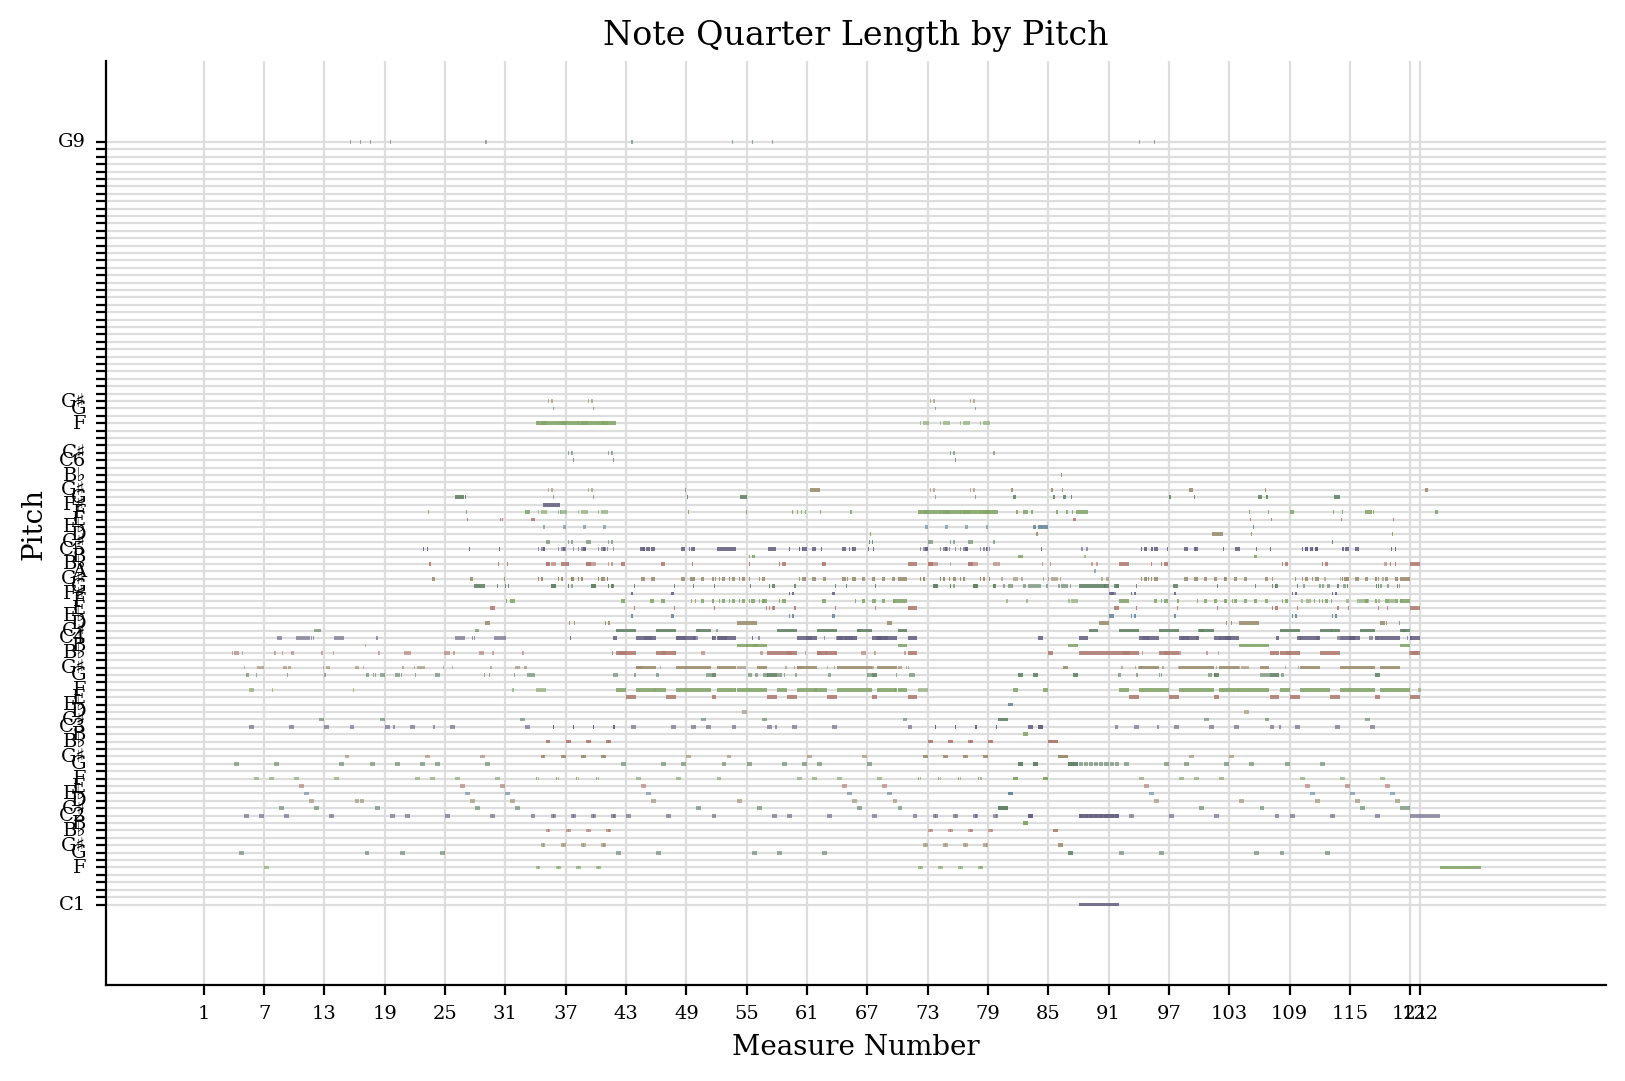

In [49]:
random_midi = m21.midi.MidiFile()
random_midi.open(random_piano_path)
random_midi.read()
random_midi.close()

random_m21stream = m21.midi.translate.midiFileToStream(random_midi)
random_m21stream.plot()

In [50]:
vocab = MusicVocab()
vocab.train(None, vocab.initial_size)

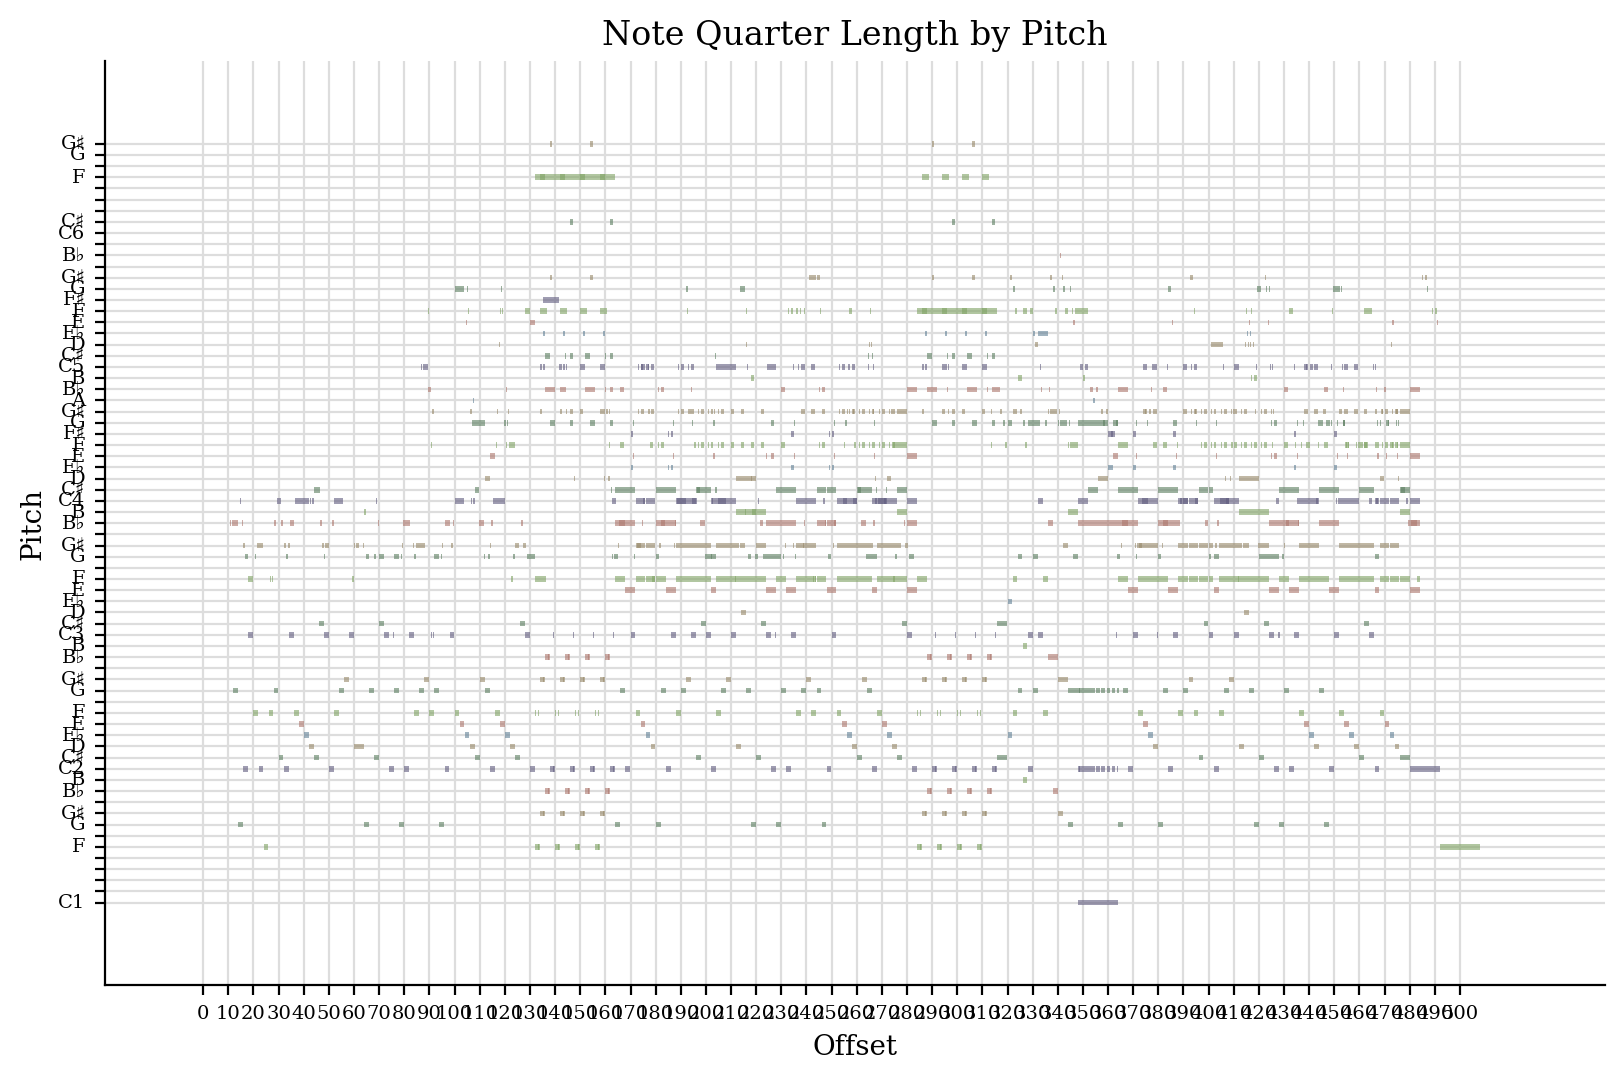

In [51]:
random_score = midifile_to_idx_score(random_piano_path, vocab)
reconstructed_random_stream = idx_to_stream_enc(random_score[:, 0], vocab)
reconstructed_random_stream.plot()

In [ ]:
reconstructed_random_stream.show('midi')

It's *almost* right but it has issues. It think it is perhaps due to the songs having 32nd notes, where our encoding has a resolution of 16ths.

Even then, I would expect that some songs would use dotted or swung notes, or just be completely off grid, and they are all being snapped to the nearest 16th?

Also, all tracks are played back at 120bpm which makes songs faster or slower than they are supposed to be but that is ok, tempo isn't encoded into the music.